# 0.0 IMPORTS


In [1]:
import math
import warnings
import inflection
import random
import pickle
import numpy               as np
import pandas              as pd
import seaborn             as sns
import xgboost             as xgb
from matplotlib            import pyplot as plt
from IPython.core.display  import HTML
from IPython.display       import Image
from tabulate              import tabulate
from pycorrcat.pycorrcat   import plot_corr, corr_matrix
from sklearn.preprocessing import RobustScaler, MinMaxScaler,LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from boruta                import BorutaPy


## 0.1 HELPER FUNCTIONS

In [2]:
def cross_validation(x_training,kfold,model_name,model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in range(kfold,0,-1):
        if verbose:
            print(f'kFold number:{k}')
        #start and end data validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days = k * 7 * 6)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1) * 7 * 6)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #training and validation dataset
        #training
        xtraining = training.drop(columns=['date','sales'])
        ytraining = training['sales']
        #validation
        xvalidation = validation.drop(columns=['date','sales'])
        yvalidation = validation['sales']
        #model
        m = model.fit(xtraining,ytraining)
        #predction
        yhat = m.predict (xvalidation)
        #performance
        m_result = ml_error('Linear Regression', np.expm1(yvalidation),np.expm1(yhat))
        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    return pd.DataFrame({'Model Name' : model_name ,
                        'MAE_CROSS': np.round(np.mean(mae_list),2).astype( str ) + ' +- ' + np.round(np.std(mae_list),2).astype( str ) ,
                        'MAPE_CROSS': np.round(np.mean(mape_list),2).astype( str ) + ' +- '+ np.round(np.std(mape_list),2).astype( str ) ,
                        'RMSE_CROSS': np.round(np.mean(rmse_list),2).astype( str ) + ' +- ' + np.round(np.std(rmse_list),2).astype( str )}, index=[0])


def mean_percentage_error(y,yhat):
    return np.mean( ( y - yhat ) / y )


def ml_error(model_name,y,yhat):
    mae = mean_absolute_error (y,yhat)
    mape = mean_absolute_percentage_error (y,yhat)
    rmse = mean_squared_error (y,yhat)
    
    return pd.DataFrame({
        'Model Name': model_name,
        'MAE': mae,
        'MAPE' : mape,
        'RMSE' : np.sqrt(rmse)
    }, index = [0])


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = 1000
    pd.options.display.max_rows = 1000
    pd.set_option( 'display.expand_frame_repr', False )    
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    sns.set()
    warnings.filterwarnings('ignore')

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/john/.pyenv/versions/3.10.5/envs/RossmanStoreSales/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# 0.2 LOAD DATA

In [4]:
df_sales_raw = pd.read_csv('train.csv', low_memory=False)
df_store_raw = pd.read_csv('store.csv', low_memory=False)
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,NaN
1,2,a,a,570.000,11.000,2007.000,1,13.000,2010.000,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.000,12.000,2006.000,1,14.000,2011.000,"Jan,Apr,Jul,Oct"
3,4,c,c,620.000,9.000,2009.000,0,NaN,NaN,NaN
4,5,a,a,29910.000,4.000,2015.000,0,NaN,NaN,NaN


# 1.0 DATA DESCRIPT

In [5]:
df1 = df_raw.copy()
df1.isna().sum()
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.000,11.000,2007.000,1,13.000,2010.000,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.000,12.000,2006.000,1,14.000,2011.000,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.000,9.000,2009.000,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.000,4.000,2015.000,0,NaN,NaN,NaN


## 1.1 RENAME COLUMNS



In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
            'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']


def snakecase(x): 
    return inflection.underscore(x)


cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

## 1.2 DATA DIMENSIONS


In [8]:
print(f'Number of rows {df1.shape[0]}')
print(f'Number of colunms {df1.shape[1]}')

Number of rows 1017209
Number of colunms 18


## 1.3 DATA TYPES


In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4CHECK NA


In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 FILLOUT NA



In [11]:
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x)
                                                                else x)
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else
                                                x['competition_open_since_month'], axis=1)
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else
                                               x['competition_open_since_year'], axis=1)
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else
                                     x['promo2_since_week'], axis=1)
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else
                                     x['promo2_since_year'], axis=1)

df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['promo_interval'].fillna(0, inplace=True)
df1['is_promo'] = df1[['month_map', 'promo_interval']].apply(lambda x: 0 if x['promo_interval'] == 0 else
                                                             1 if x['month_map'] in x['promo_interval'].split(',') else
                                                             0, axis=1)

## 1.6 CHANGE TYPES

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(
    int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(
    int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 DESCRIPTIVE STATISTICAL

In [13]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(
    exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 NUMERICAL ATTRIBUTES

In [14]:
# CENTRAL:  TENDENCY - MEAN - MEDIAN
# DISPERSION: STD, MIN, MAX, RANGE, SKEW, KURTOSIS
num_attributes.agg(["min", "max", "mean", "median",
                   "std", "skew", "kurtosis"]).T

,min,max,mean,median,std,skew,kurtosis
store,1.000,1115.000,558.430,558.000,321.909,-0.001,-1.201
day_of_week,1.000,7.000,3.998,4.000,1.997,0.002,-1.247
sales,0.000,41551.000,5773.819,5744.000,3849.926,0.641,1.778
customers,0.000,7388.000,633.146,609.000,464.412,1.599,7.092
open,0.000,1.000,0.830,1.000,0.376,-1.758,1.091
promo,0.000,1.000,0.382,0.000,0.486,0.488,-1.762
school_holiday,0.000,1.000,0.179,0.000,0.383,1.678,0.815
competition_distance,20.000,200000.000,5935.443,2330.000,12547.653,10.242,147.790
competition_open_since_month,1.000,12.000,6.787,7.000,3.311,-0.042,-1.233
competition_open_since_year,1900.000,2015.000,2010.325,2012.000,5.516,-7.236,124.071


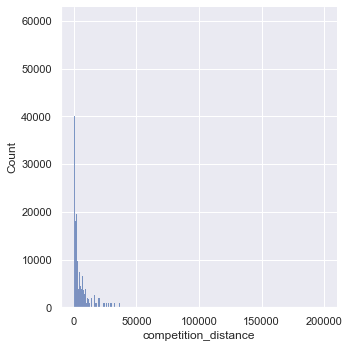

In [15]:
sns.displot(df1['competition_distance'])

### 1.7.2 CATEGORICAL ATTRIBUTES

In [16]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

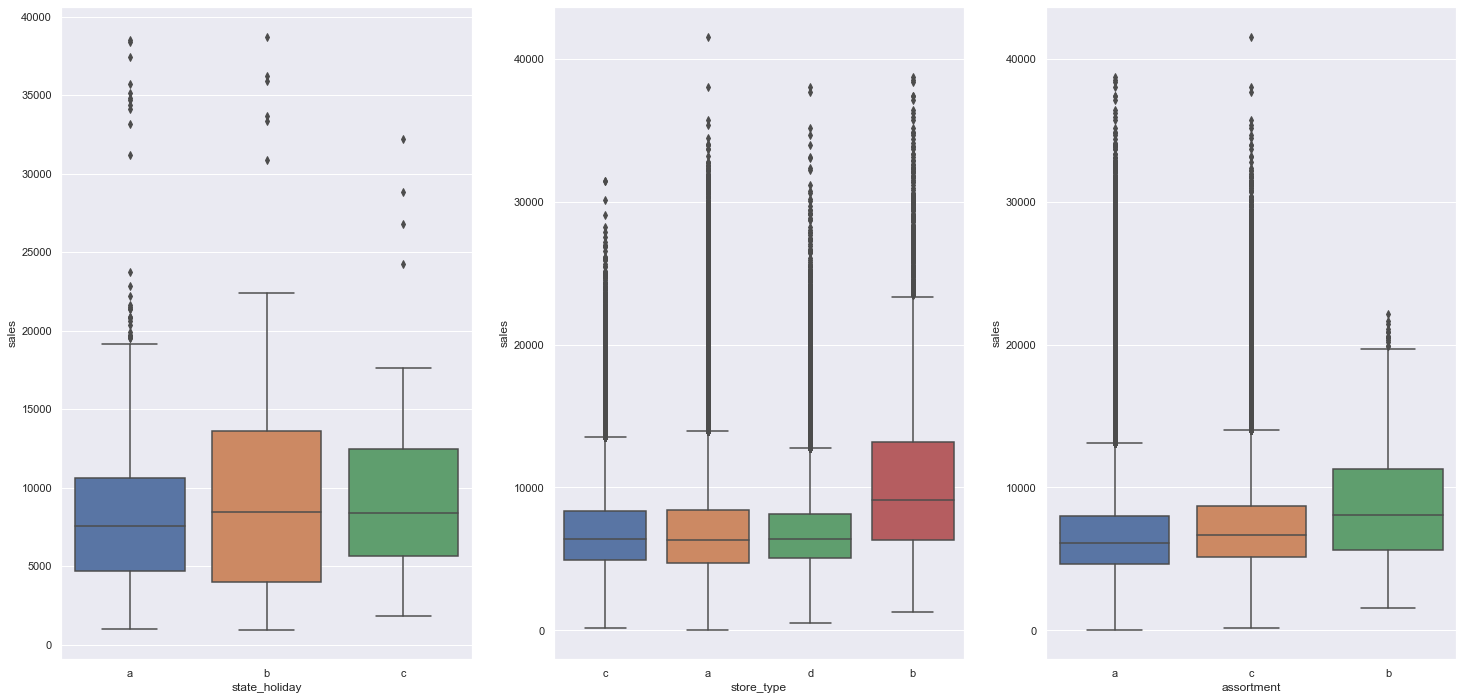

In [17]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] != 0)]
aux2 = df1[df1['sales'] != 0]
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)
plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux2)
plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux2)

# 2.0 FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

## 2.1 HYPOTHESIS MIND MAP


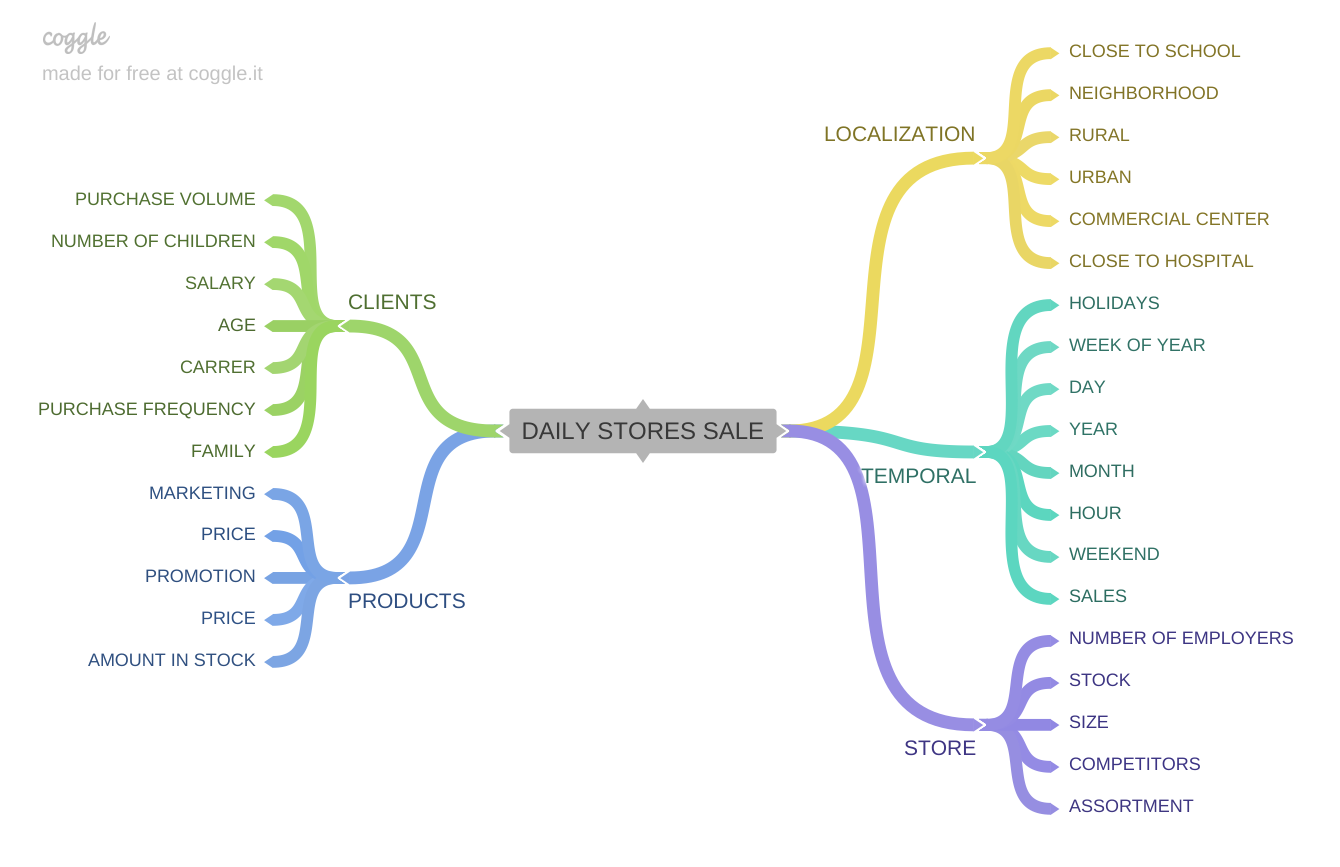

In [19]:
Image('img/DAILY_STORES_SALE.png')

## 2.2 CREATION OF HYPOTHESES

### 2.2.1 STORE HYPOTHESES

**1** Stores with more employees sell more  
**2** Stores with the most inventory sell the most  
**3** Largest stores sell more  
**4** Smaller stores sell less  
**5** Stores with the Largest Assortment Sell More  

### 2.2.2 PRODUCT HYPOTHESES

**1** Stores that invest more in marketing sell more  
**2** Stores that display more products in their windows sell more  
**3** Stores with lower prices sell more  
**4** Stores with lower prices on products for longer sell more  

### 2.2.3 TEMPORAL HYPOTHESES

**1** Stores that have holidays sell less  
**2** Stores that open in the first 6 months should sell more  
**3** Stores that open on weekends should sell more  

### 2.2.4 FINAL LIST HYPOTHESES 

**1** Stores with the Largest Assortment Sell More    
**2** Stores with close competitors should sell less    
**3** Stores with longer competitors should sell more    
**4** Stores with promotions active for longer should sell more  
**5** Stores with more days of promotions should sell more    
**6** Stores with more consecutive promotions should sell more  
**7** Stores open during the Christmas holiday should sell more  
**8** Stores should sell more over the years      
**9** Stores should sell more after the 10th of each month  
**10** Stores should sell more in the second half
**11** Stores should sell less on weekends  
**12** Stores should sell less during school holidays  
 

## 2.3 FEATURE ENGINEERING

In [20]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year of week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')
# competition since
df2['competition_since'] = df2.apply(lambda x : datetime.datetime(year = x['competition_open_since_year'] , month = x['competition_open_since_month'], day=1), axis = 1)
df2['competition_since_month'] = (df2['date']-df2['competition_since']).apply(lambda x : int((x.days)/30))
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x : datetime.datetime.strptime(x + '-1','%Y-%W-%w')) - datetime.timedelta(days = 7)
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) /7 ).apply(lambda x : x.days).astype( int )
# assortment
df2['assortment'] = df2['assortment'].apply(lambda x : 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended') 
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x : 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christimas' if x == 'c' else 'regular_day')



In [21]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_since_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.000,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.000,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.000,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.000,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.000,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 3.0 VARIABLE FILTERING

In [22]:
df3 = df2.copy()

## 3.1 ROW SELECTION

In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 COLUMNS SELECTION 

In [24]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(columns = cols_drop)

In [25]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_since_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.000,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.000,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.000,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.000,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.000,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 4.0 EDA - EXPLORATORY DATA ANALYSIS

In [26]:
df4 = df3.copy()

## 4.1 UNIVARIATE ANALYSIS

### 4.1.1 RESPONSE VARIABLE

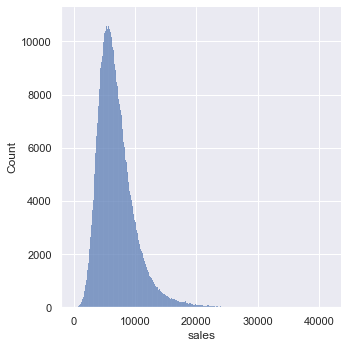

In [27]:
sns.displot(df4['sales'], kde = False);

### 4.1.2 NUMERICAL VARIABLE

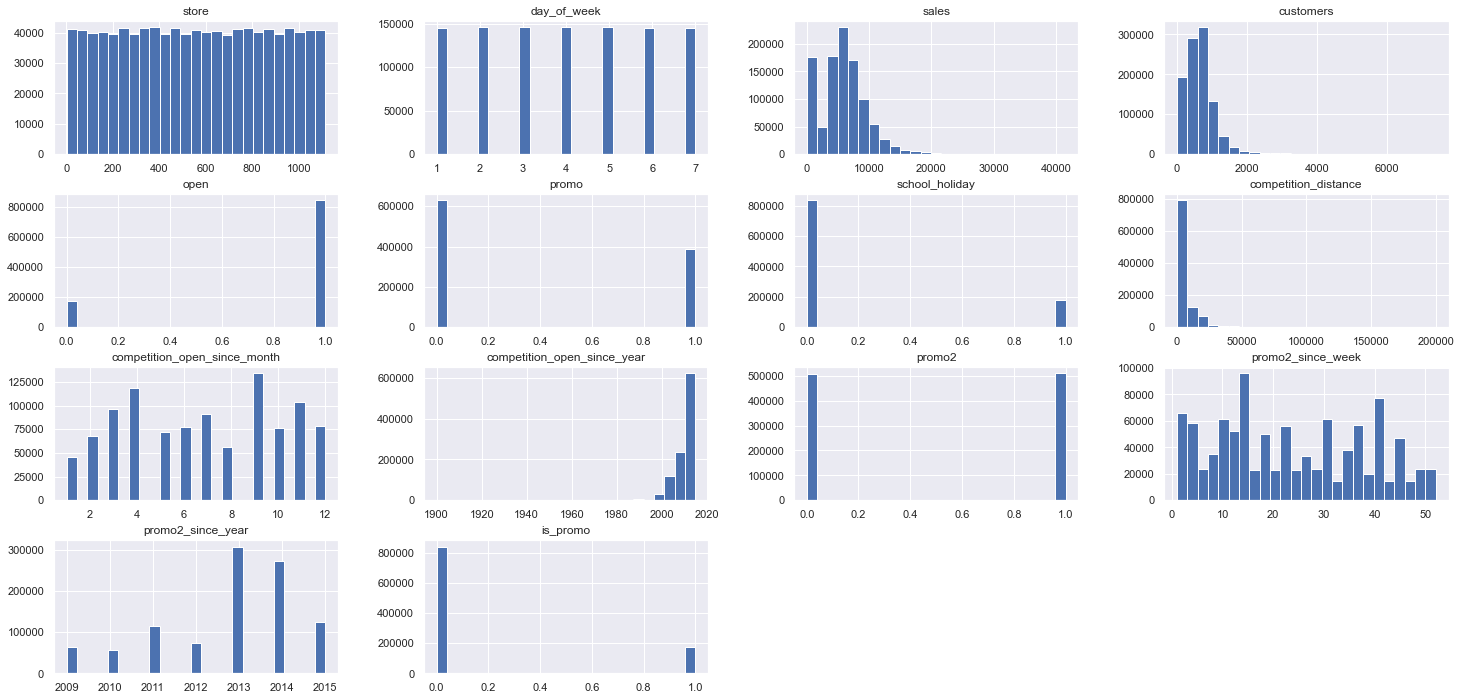

In [28]:
num_attributes.hist(bins = 25);

### 4.1.3 CATEGORICAL VARIABLE

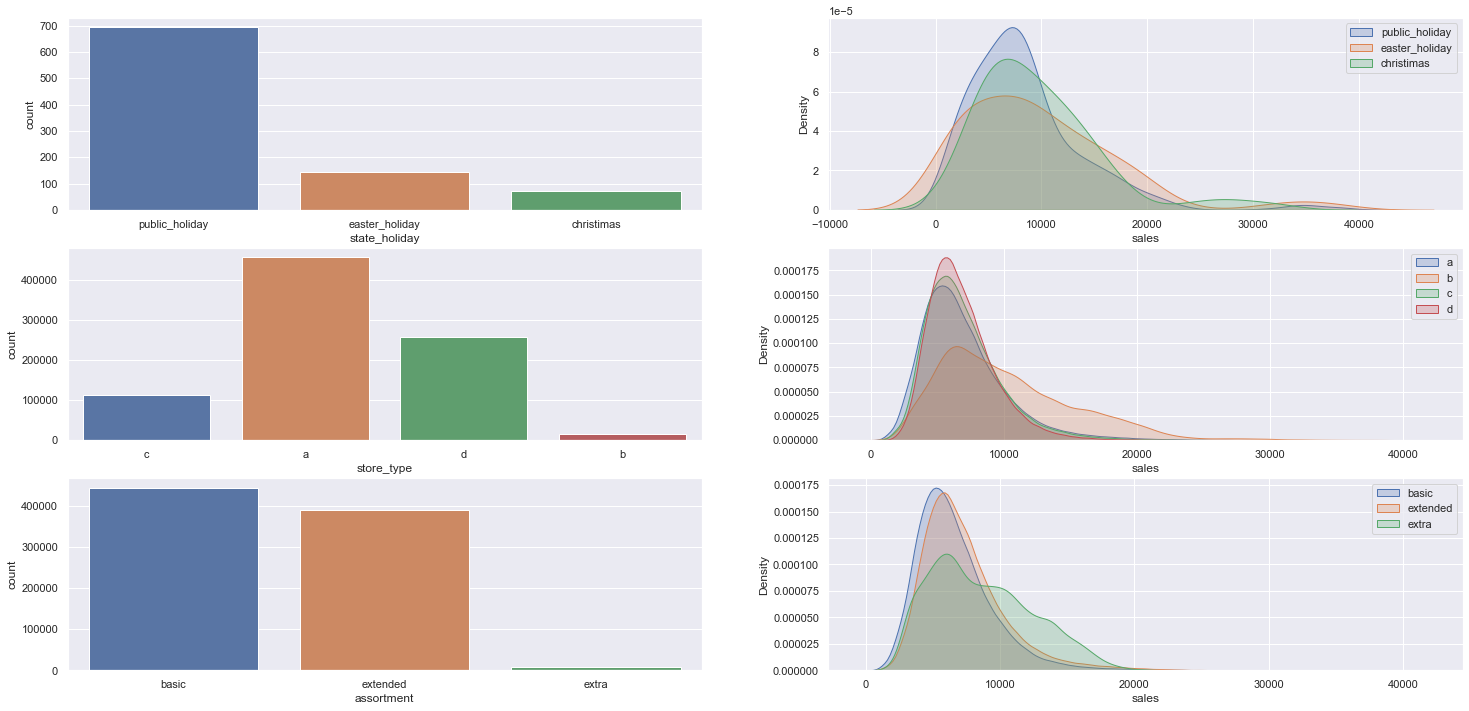

In [29]:
#state_holiday
plt.subplot(3,2,1)
sns.countplot(df4[df4['state_holiday'] != 'regular_day']['state_holiday']);
plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True);
sns.kdeplot(df4[df4['state_holiday'] == 'christimas']['sales'], label = 'christimas', shade = True);
plt.legend()

#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type']);
plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True);
plt.legend()

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment']);
plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True);
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True);
plt.legend();

## 4.2 BIVARIATE ANALYSIS

### **H1** Stores with the Largest Assortment Sell More
**FALSE** STORES WITH LARGEST ASSORTMENT SELL LESS

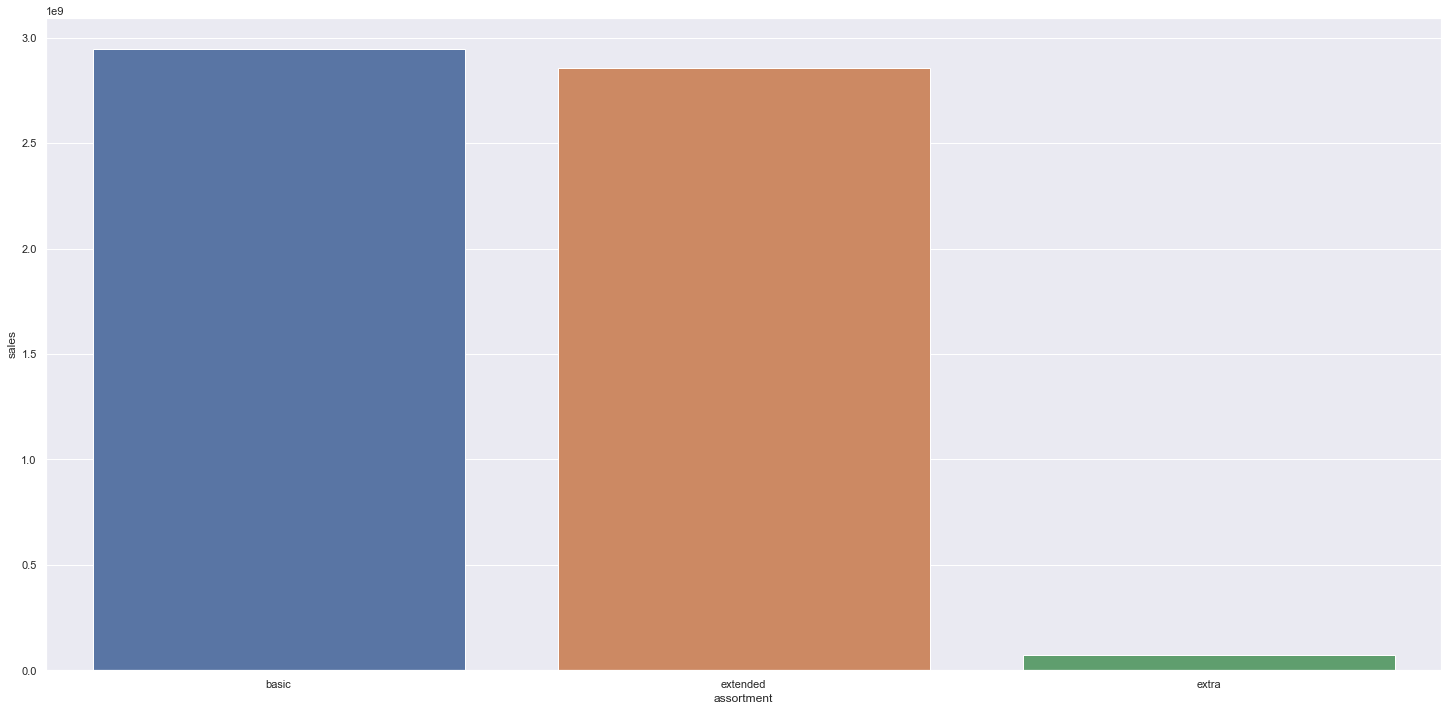

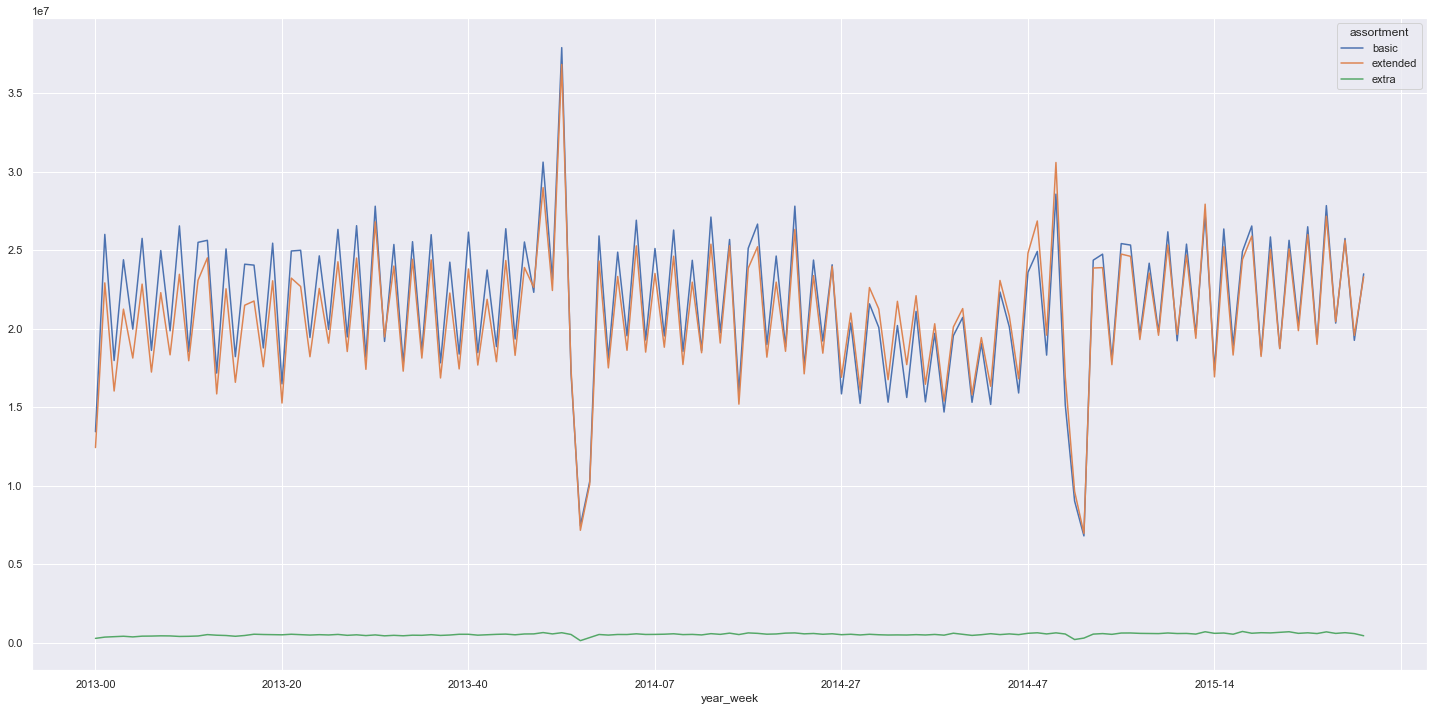

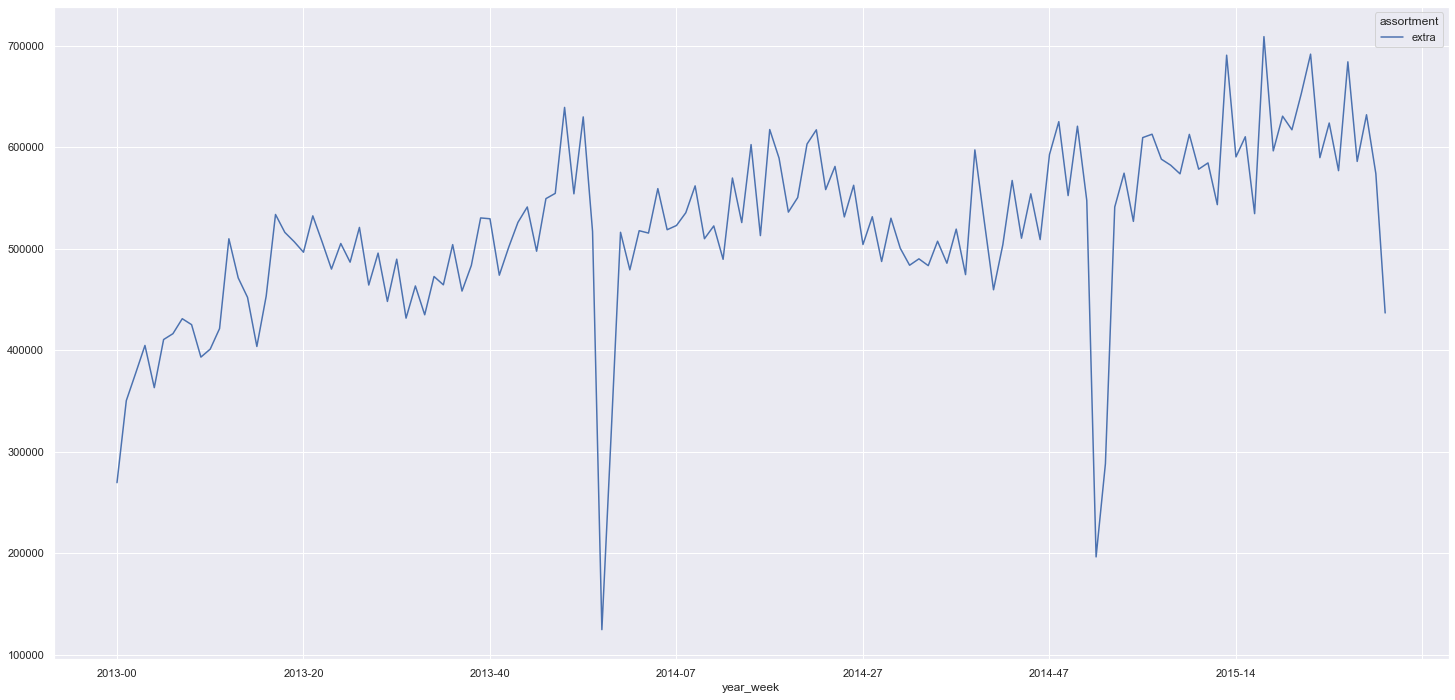

In [30]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(data = aux1, x = 'assortment', y = 'sales');
aux2 = df4[['assortment','sales','year_week']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index ='year_week' ,columns = 'assortment' ,values ='sales').plot();
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index ='year_week' ,columns = 'assortment' ,values ='sales').plot();

### **H2** Stores with close competitors should sell less    
**FALSE** STORES WITH CLOSE COMPETITOR SELL MORE


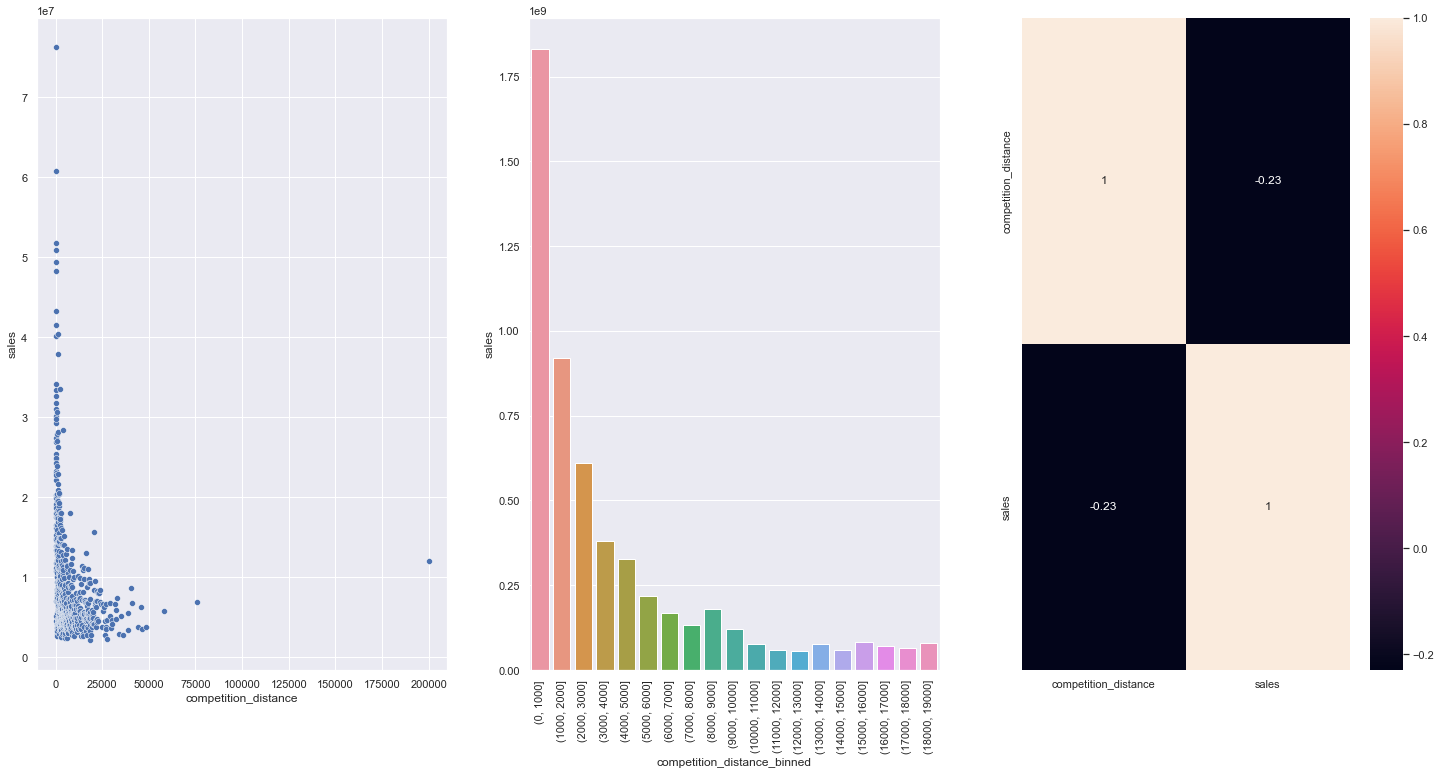

In [31]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
bins = list(np.arange(0,20000,1000))
plt.subplot(1,3,1)
sns.scatterplot(data = aux1, x = 'competition_distance', y = 'sales');
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins = bins )
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
plt.subplot(1,3,2)
sns.barplot(data = aux2, x = 'competition_distance_binned', y = 'sales');
plt.xticks(rotation = 90);
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method= 'pearson'), annot= True);

### **H3** Stores with longer competitors should sell more    
**FALSE** Stores with longer competitors sell less

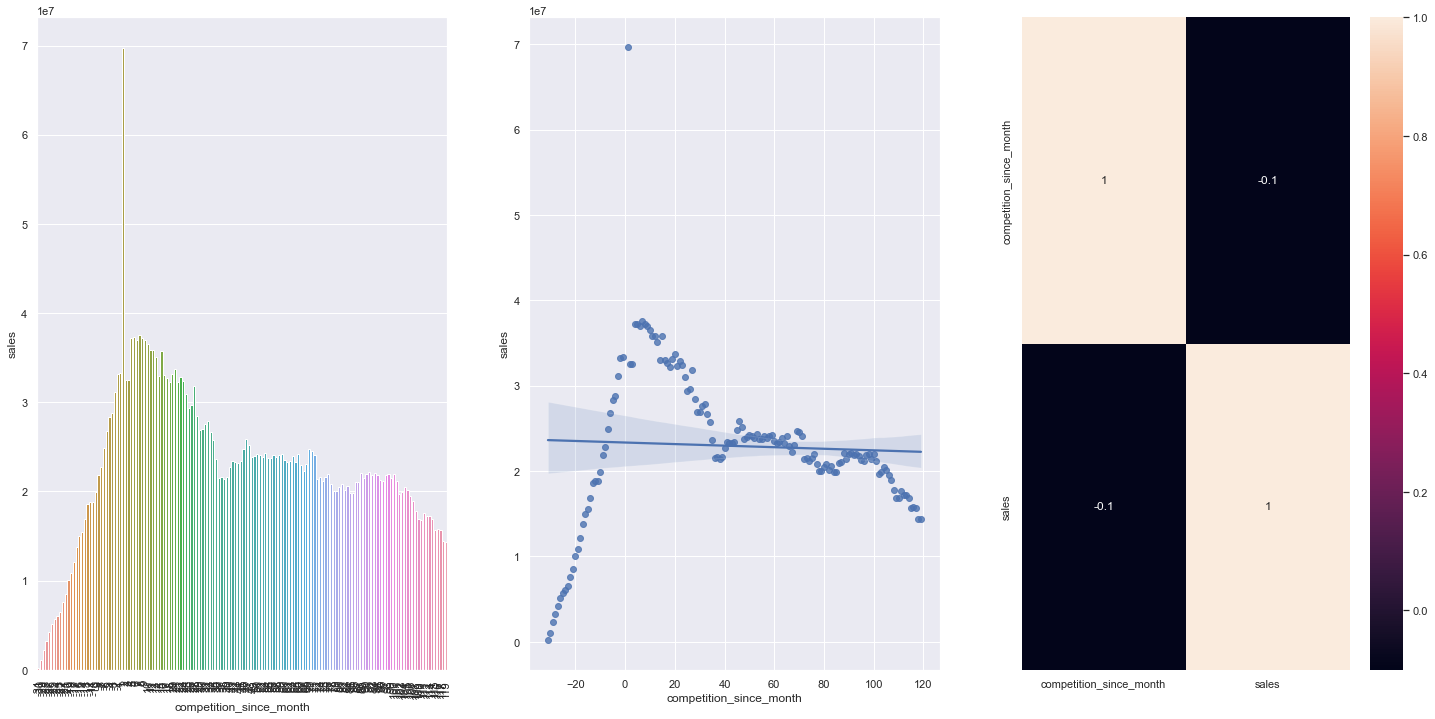

In [32]:
aux1 = df4[['competition_since_month',
              'sales']].groupby('competition_since_month').sum().reset_index()
aux2 = aux1[(aux1['competition_since_month'] < 120) & (aux1['competition_since_month'] != 0)]
plt.subplot(1,3,1);
sns.barplot(x='competition_since_month', y='sales', data=aux2);
plt.xticks(rotation=90);
plt.subplot(1,3,2)
sns.regplot(x='competition_since_month', y='sales', data=aux2);
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot= True);

### H4 Stores with promotions active for longer should sell more  
**FALSE** Stores with active promotions sell less, after a certain time

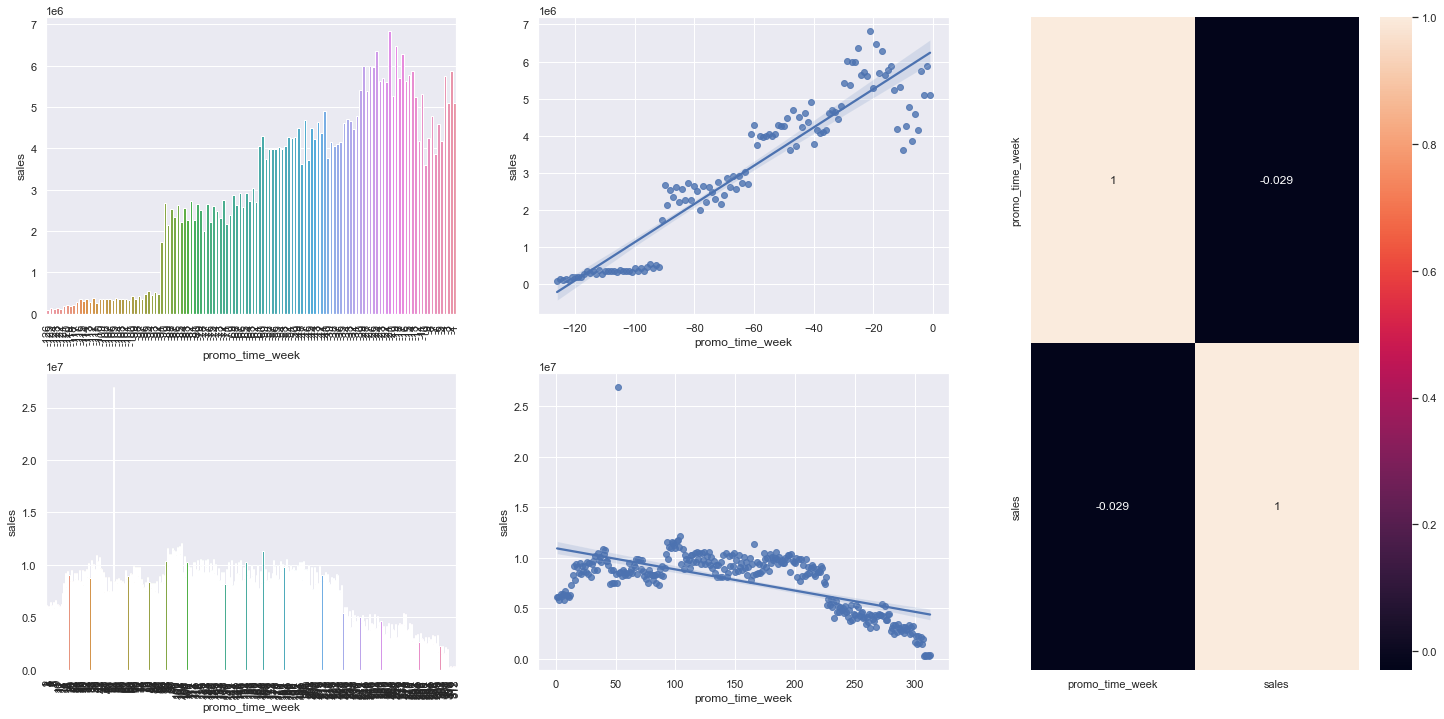

In [33]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
aux2 = aux1[aux1['promo_time_week'] > 0]
aux3 = aux1[aux1['promo_time_week'] < 0]
grid = GridSpec(2,3)
plt.subplot(grid[0,0]);
sns.barplot(x= 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation = 90);
plt.subplot(grid[0,1]);
sns.regplot(x= 'promo_time_week', y = 'sales', data = aux3);
plt.subplot(grid[1,0]);
sns.barplot(x= 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);
plt.subplot(grid[1,1]);
sns.regplot(x= 'promo_time_week', y = 'sales', data = aux2);
plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### <s>H5 Stores with more days of promotions should sell more</s>    

### H6 Stores with more consecutive promotions should sell more  
**FALSE** Stores with consecutive promotions sell less

In [34]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


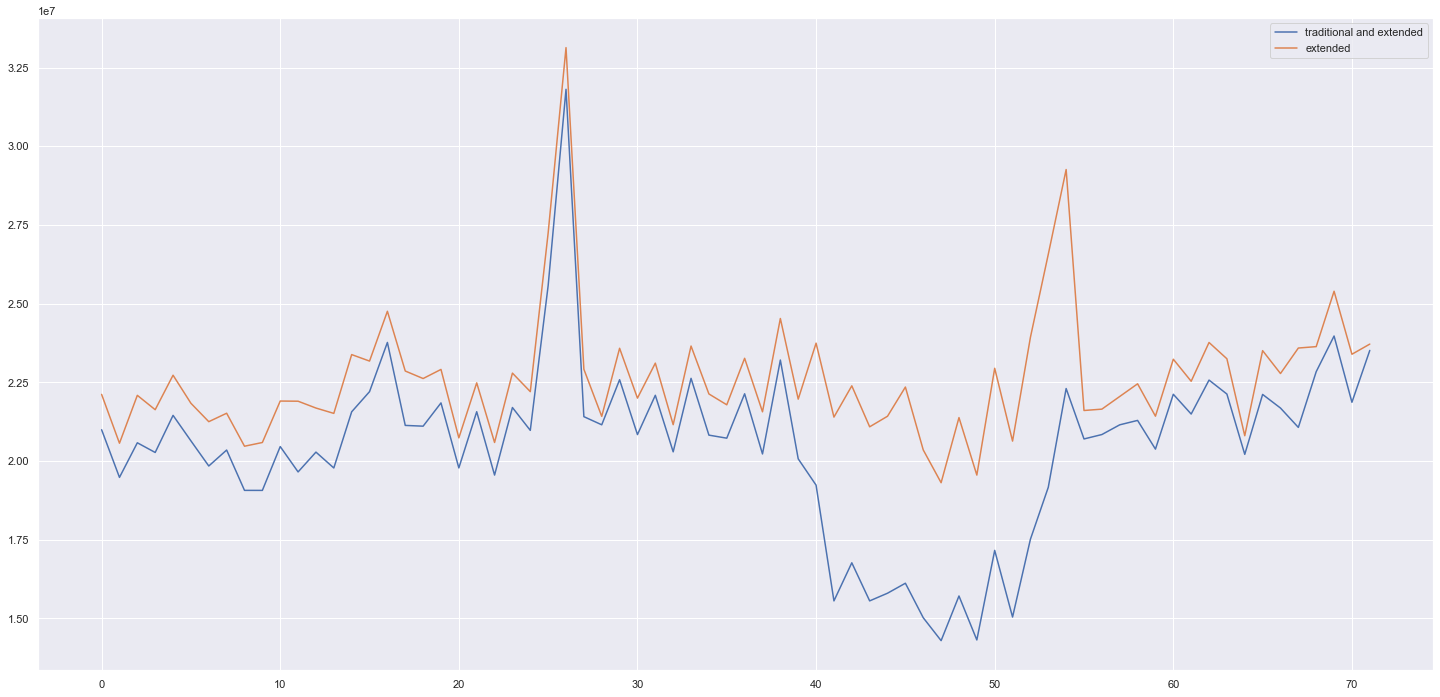

In [35]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);
ax.legend(labels = (['traditional and extended','extended']));

### H7 Stores open during the Christmas holiday should sell more  
**FALSE** Stores opened during the Christmas holiday sell less

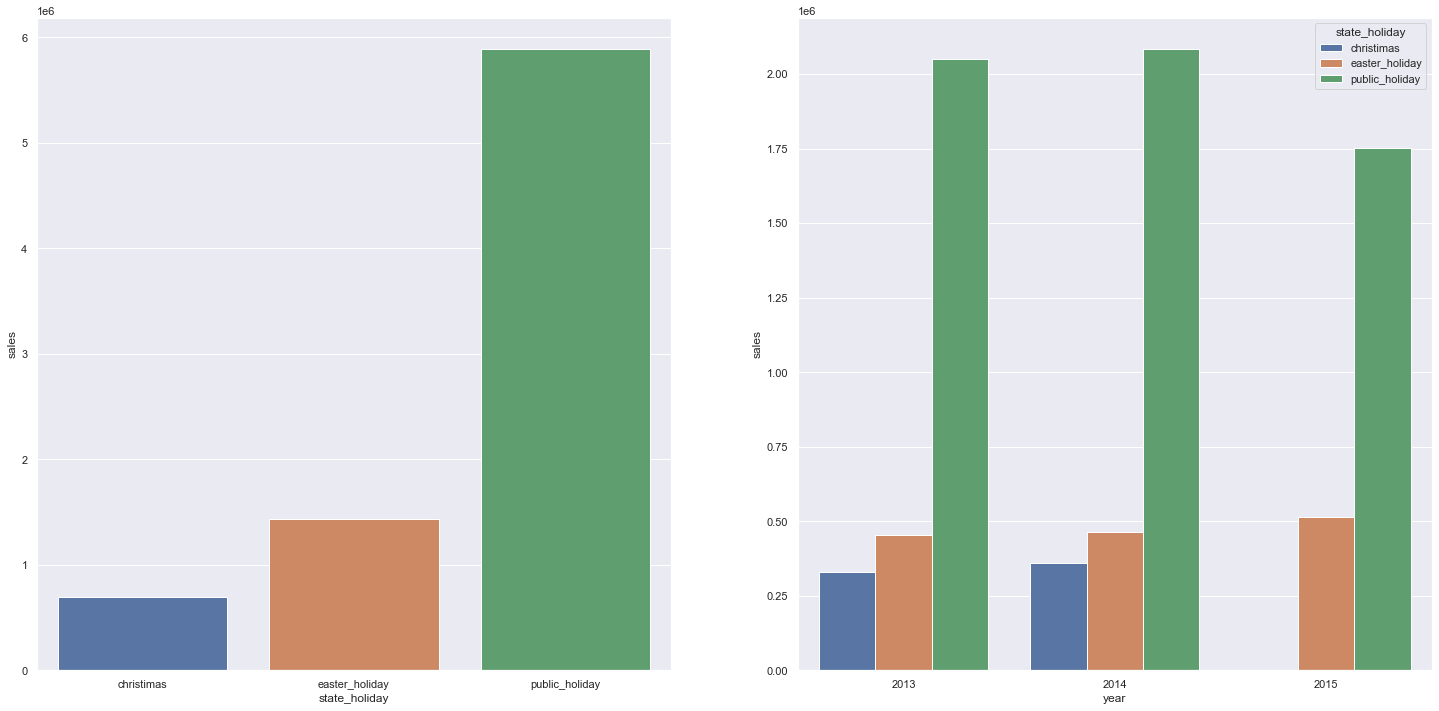

In [36]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['sales','state_holiday']].groupby('state_holiday').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(data = aux1, x='state_holiday', y='sales');
aux2 = aux[['year', 'sales', 'state_holiday']].groupby(['year', 'state_holiday']).sum().reset_index()
plt.subplot(1,2,2)
sns.barplot(data = aux2, x= 'year', y = 'sales', hue = 'state_holiday');

### H8 Stores should sell more over the years      
**FALSE** Stores sell less over the years

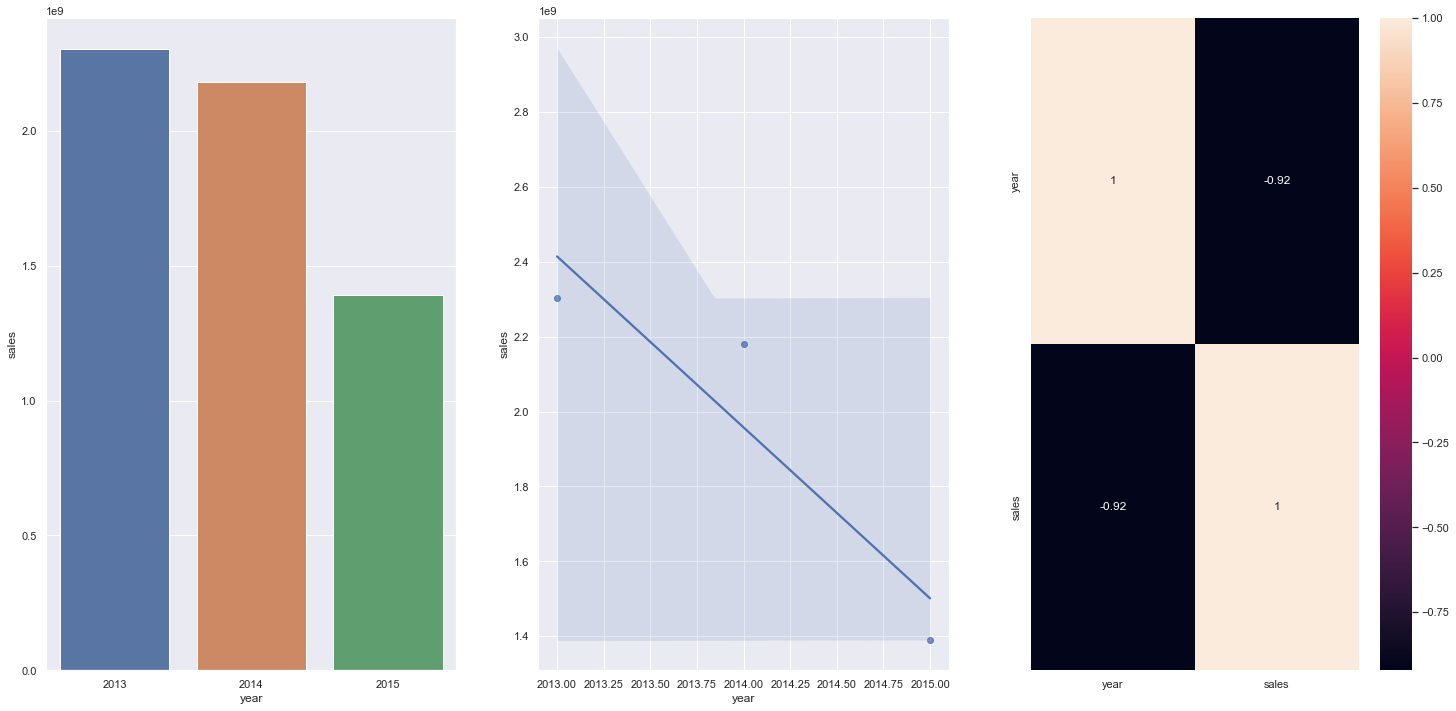

In [37]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(data = aux1, x= 'year', y = 'sales')
plt.subplot(1,3,2)
sns.regplot(data = aux1, x= 'year', y = 'sales')
plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method = 'pearson'),annot=True);

### H9 Stores should sell more after the 10th of each month 
**TRUE** Stores sell more after the 10th of each month 

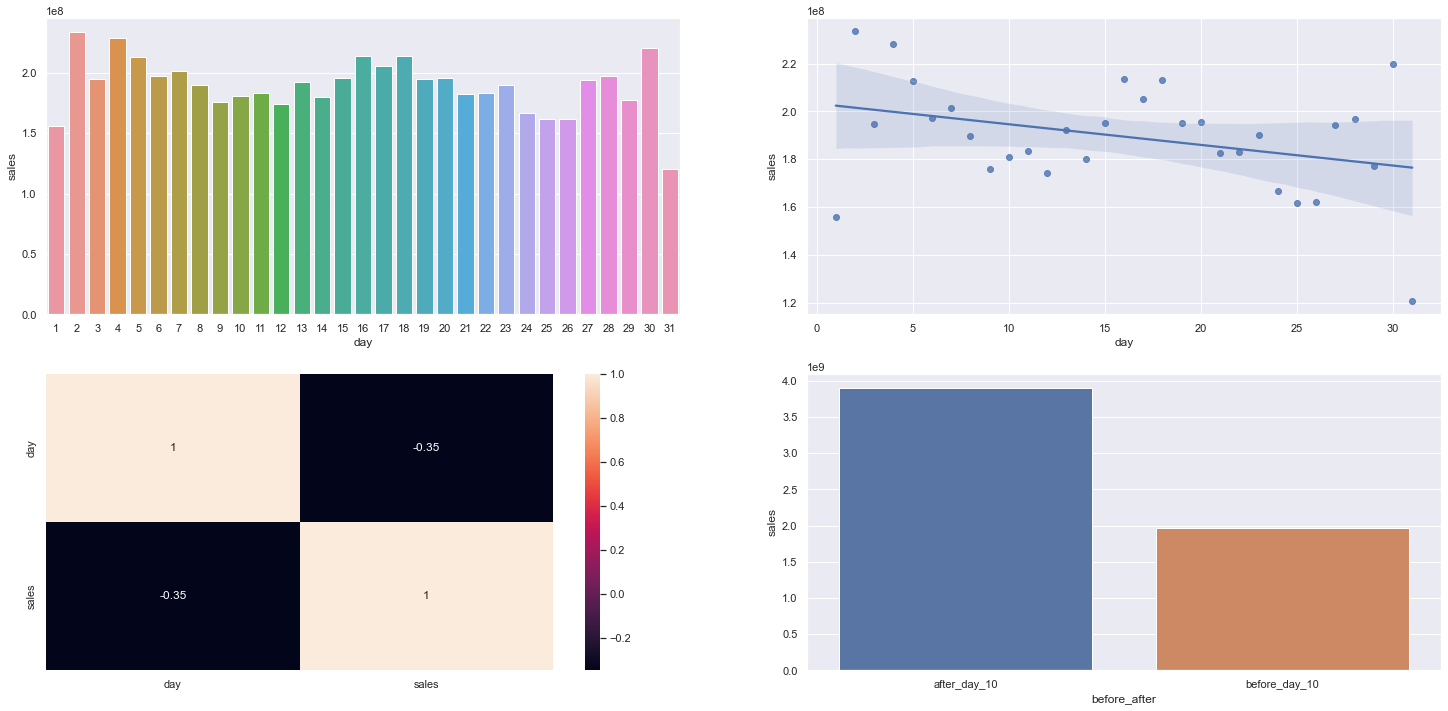

In [38]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(data = aux1, x= 'day', y = 'sales')

plt.subplot(2,2,2)
sns.regplot(data = aux1, x= 'day', y = 'sales')

plt.subplot(2,2,3)
sns.heatmap(aux1.corr( method = 'pearson'),annot=True);

aux1['before_after'] = aux1['day'].apply( lambda x : 'before_day_10' if x <= 10 else 'after_day_10')
aux1 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
plt.subplot(2,2,4)
sns.barplot( x='before_after', y = 'sales', data = aux1);  


### H10 Stores should sell more in the second half
**TRUE** Stores sell more in the second half

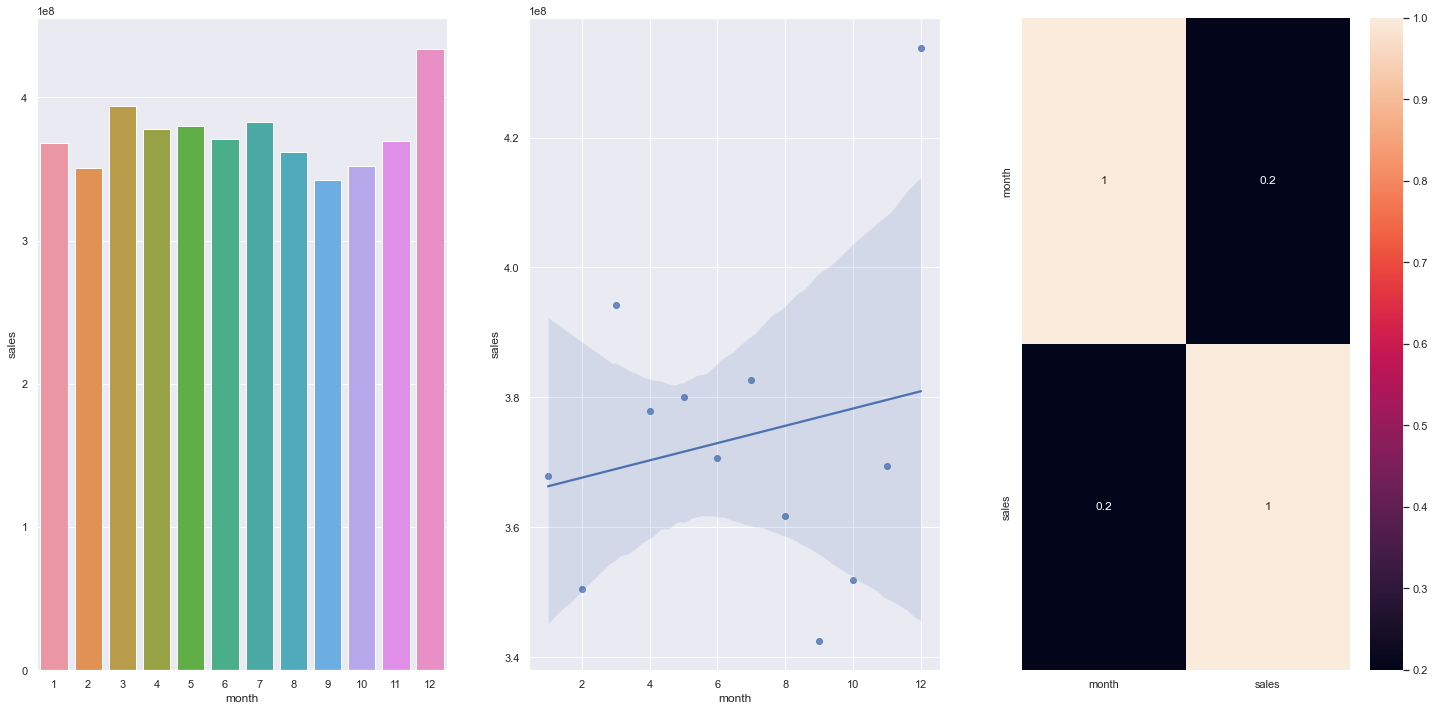

In [39]:
aux1 = df4[df4['year']<2015][['month','sales']].groupby('month').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(data = aux1, x= 'month', y = 'sales')
plt.subplot(1,3,2)
sns.regplot(data = aux1, x= 'month', y = 'sales')
plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method = 'pearson'),annot=True);

### H11 Stores should sell less on weekends  
**TRUE** Stores sell less on weekends  

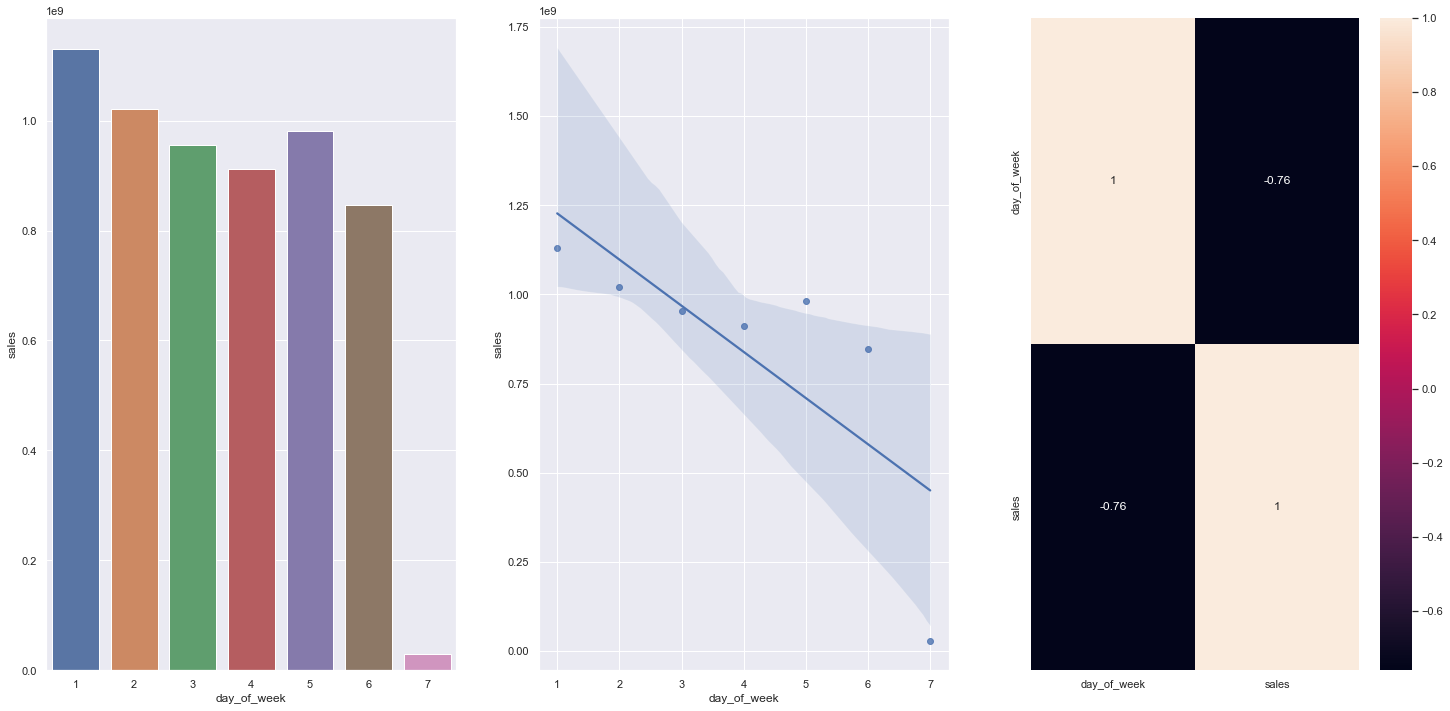

In [40]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(data = aux1, x= 'day_of_week', y = 'sales')
plt.subplot(1,3,2)
sns.regplot(data = aux1, x= 'day_of_week', y = 'sales')
plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method = 'pearson'),annot=True);

### H12 Stores should sell less during school holidays  
**TRUE** Stores sell less during school holidays 

<AxesSubplot:xlabel='month', ylabel='sales'>

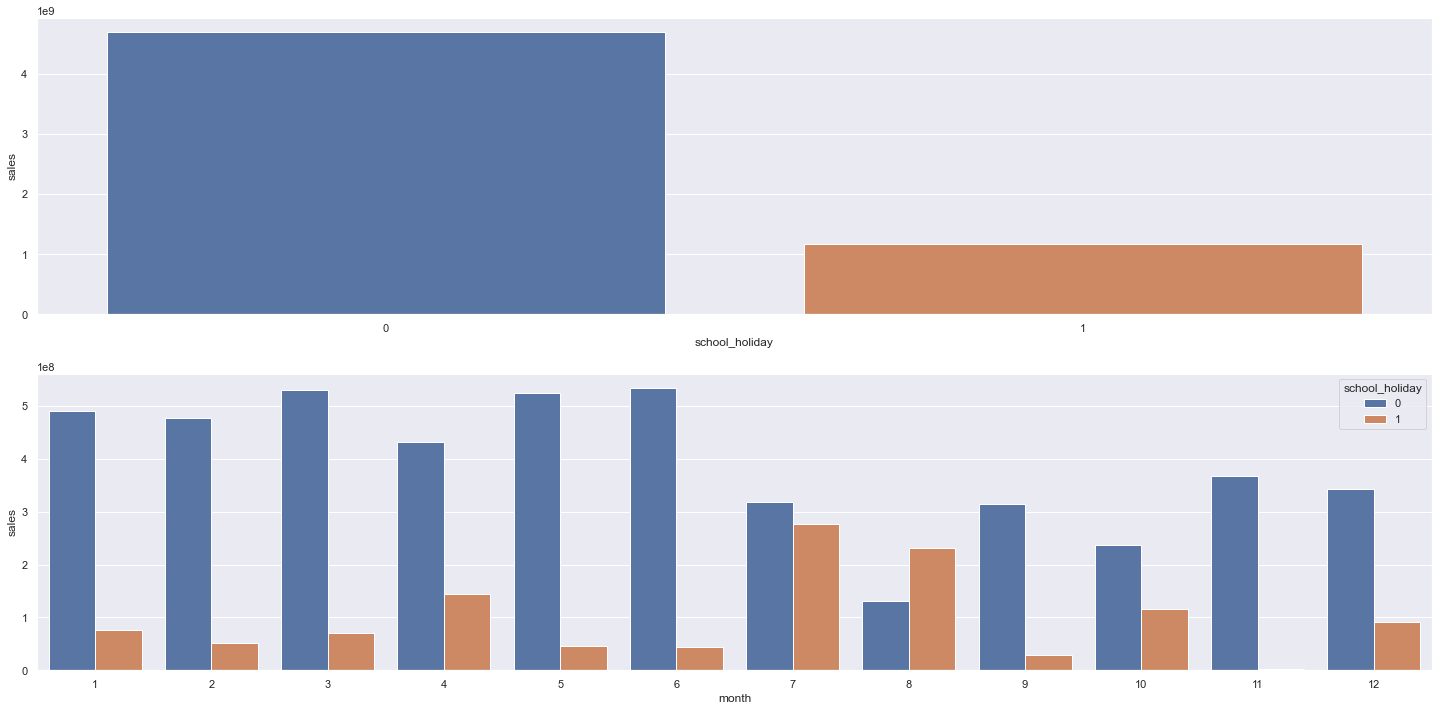

In [41]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(data = aux1, x= 'school_holiday', y='sales');
aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(data = aux2, x = 'month', y= 'sales', hue = 'school_holiday')

### 4.2.1 Summary of hypotheses


In [42]:
tab = [['hypotheses','conclusion', 'relevance'],
      ['H1','False','low'],
      ['H2','False','average'],
      ['H3','False','average'],
      ['H4','False','low'],
      ['H5','----','----'],
      ['H6','False','low'],
      ['H7','False','average'],
      ['H8','False','high'],
      ['H9','False','high'],
      ['H10','True','high'],
      ['H11','True','high'],
      ['H12','True','low']
      ]
print(tabulate(tab, headers='firstrow'))


hypotheses    conclusion    relevance
------------  ------------  -----------
H1            False         low
H2            False         average
H3            False         average
H4            False         low
H5            ----          ----
H6            False         low
H7            False         average
H8            False         high
H9            False         high
H10           True          high
H11           True          high
H12           True          low


## 4.3 Multivariate analysis

## 4.3.1 Numerical atributes

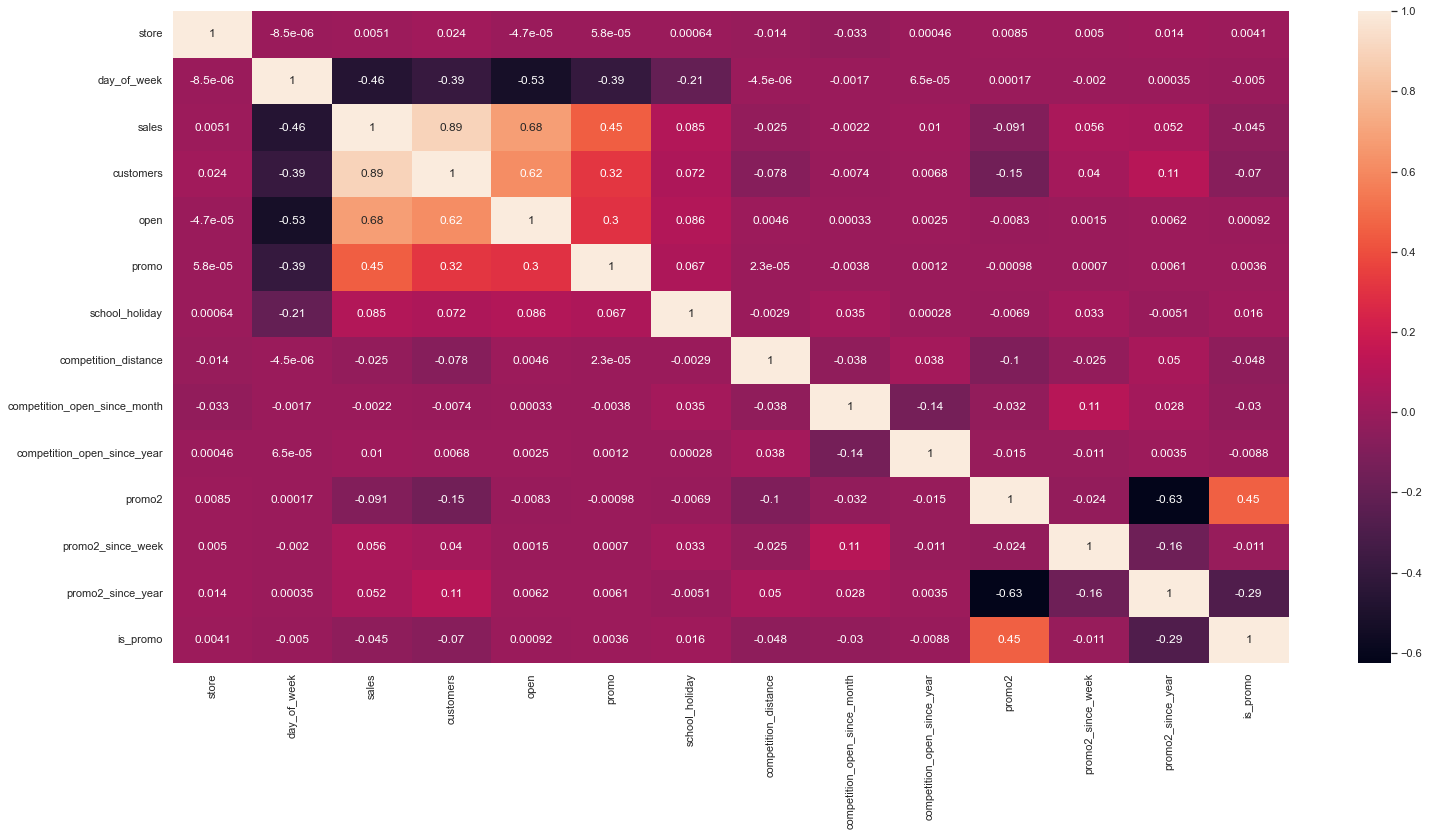

In [43]:
correlation_num = num_attributes.corr(method='pearson')
sns.heatmap(correlation_num, annot = True );

## 4.3.2 Categorical atributes

In [44]:
cat_atributes = df4.select_dtypes( include = 'object' )
cat_atributes.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


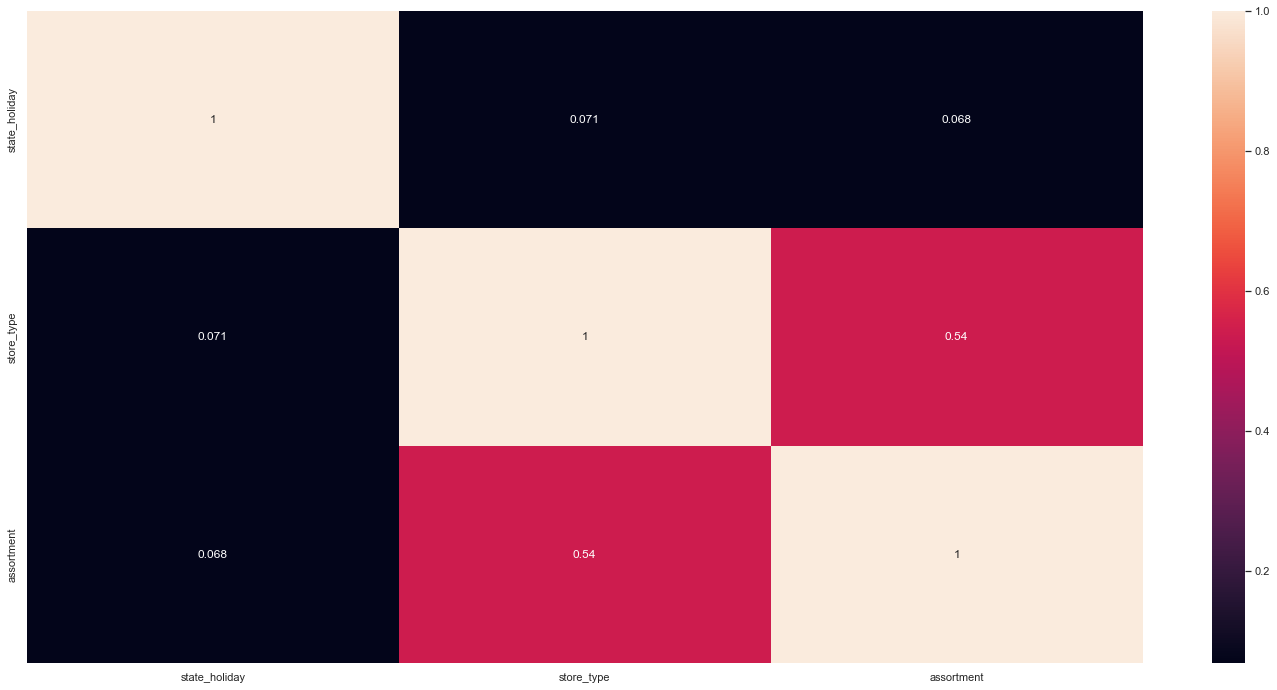

In [45]:
correlation_matrix = corr_matrix(cat_atributes,['state_holiday','store_type','assortment'] )
sns.heatmap(correlation_matrix,annot=True);

# 5.0 DATA PREPARATION

In [46]:
df5 = df4.copy()
df5['week_of_year'] = df5['week_of_year'].astype(int64)
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_since_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.000,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.000,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.000,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.000,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.000,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 5.1 NORMALIZATION

## 5.2 RESCALING

In [47]:
rs = RobustScaler()
mms = MinMaxScaler()
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance'
                                                    ]].values)
df5['competition_since_month'] = rs.fit_transform(
    df5[['competition_since_month']].values)
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3 TRANSFORMATION

### 5.3.1 ENCODING

In [48]:
#STATE_HOLIDAY - ONE HOT ENCODING
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#STORE_TYPE - LABEL ENCODING
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#ASSORTMENT - ORDINAL ENCODING
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [49]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_since_month,promo_since,promo_time_week,state_holiday_christimas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.171,9,2008,0,31,2015,0,1.000,7,31,31,2015-30,2008-09-01,0.919,2015-07-27,0.287,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.284,11,2007,1,13,2010,1,1.000,7,31,31,2015-30,2007-11-01,1.054,2010-03-22,0.923,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903,12,2006,1,14,2011,1,1.000,7,31,31,2015-30,2006-12-01,1.203,2011-03-28,0.802,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.276,9,2009,0,31,2015,0,1.000,7,31,31,2015-30,2009-09-01,0.743,2015-07-27,0.287,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448,4,2015,0,31,2015,0,1.000,7,31,31,2015-30,2015-04-01,-0.162,2015-07-27,0.287,0,0,0,1


### 5.3.2 RESPONSE VARIABLE TRANSFORMATION

In [50]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 NATURE TRANSFORMATION

In [51]:
# -- Cyclic Nature --
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(
    lambda x: np.sin(x * (2. * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(
    lambda x: np.cos(x * (2. * np.pi / 7)))
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))
# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))
# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(
    lambda x: np.sin(x * (2. * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(
    lambda x: np.cos(x * (2. * np.pi / 52)))

# 6.0 FEATURE SELECTION

In [52]:
df6 = df5.copy()

## 6.1 SPLIT DATAFRAME INTO TRAINING AND TEST DATASET

In [53]:
cols_drop = [
    'week_of_year', 'day', 'month', 'day_of_week', 'promo_since',
    'competition_since', 'year_week'
]
df6 = df6.drop(cols_drop, axis=1)

# TRAINING DATA SET
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# TEST DATASET
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print(f'Training Min date = {X_train["date"].min()}')
print(f'Training Max date = {X_train["date"].max()}')
print(f'\nTest Min date = {X_test["date"].min()}')
print(f'Test Max date = {X_test["date"].max()}')

Training Min date = 2013-01-01 00:00:00
Training Max date = 2015-06-18 00:00:00

Test Min date = 2015-06-19 00:00:00
Test Max date = 2015-07-31 00:00:00


In [54]:
X_test.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_since_month,promo_time_week,state_holiday_christimas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,2015-07-31,8.569,1,1,2,1,-0.171,9,2008,0,31,2015,0,1.000,0.919,0.287,0,0,0,1,-0.975,-0.223,-0.500,-0.866,0.208,0.978,-0.568,-0.823
1,2,2015-07-31,8.710,1,1,0,1,-0.284,11,2007,1,13,2010,1,1.000,1.054,0.923,0,0,0,1,-0.975,-0.223,-0.500,-0.866,0.208,0.978,-0.568,-0.823
2,3,2015-07-31,9.026,1,1,0,1,1.903,12,2006,1,14,2011,1,1.000,1.203,0.802,0,0,0,1,-0.975,-0.223,-0.500,-0.866,0.208,0.978,-0.568,-0.823
3,4,2015-07-31,9.547,1,1,2,3,-0.276,9,2009,0,31,2015,0,1.000,0.743,0.287,0,0,0,1,-0.975,-0.223,-0.500,-0.866,0.208,0.978,-0.568,-0.823
4,5,2015-07-31,8.481,1,1,0,1,4.448,4,2015,0,31,2015,0,1.000,-0.162,0.287,0,0,0,1,-0.975,-0.223,-0.500,-0.866,0.208,0.978,-0.568,-0.823


## 6.2 BORUTA AS FEATURE SELECTOR

In [55]:
# # Comment this code to save time. Boruta takes to long
# # TRAINING AND TEST DATA SET FOR BOTURA
# x_train_n = X_train.drop(columns=['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# #RANDOM FOREST REGRESSOR
# rf = RandomForestRegressor(n_jobs=-1)
# #BORUTA
# boruta = BorutaPy(
#     rf,
#     n_estimators=10,
#     verbose=2,
#     random_state=42,
# ).fit(x_train_n, y_train_n)

In [56]:
# # comment this code to save time. Boruta takes to long
# cols_selected = boruta.support_.tolist()
# x_train_fs = X_train.drop(['date', 'sales'], axis=1)
# cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.tolist()
# cols_not_selected_boruta = list(
#     np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

In [57]:
#  'cols_selected_boruta'
#  'store',
#  'promo',
#  'store_type',
#  'assortment',
#  'competition_distance',
#  'competition_open_since_month',
#  'competition_open_since_year',
#  'promo2',
#  'promo2_since_week',
#  'promo2_since_year',
#  'competition_since_month',
#  'promo_time_week',
#  'day_of_week_sin',
#  'day_of_week_cos',
#  'month_cos',
#  'day_sin',
#  'day_cos',
#  'week_of_year_cos'

## 6.3 MANUAL FEATURE SELECTION

In [58]:
cols_selected_boruta = [
    'store', 'promo', 'store_type', 'assortment', 'competition_distance',
    'competition_open_since_month', 'competition_open_since_year', 'promo2',
    'promo2_since_week', 'promo2_since_year', 'competition_since_month',
    'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_cos',
    'month_sin', 'day_sin', 'day_cos', 'week_of_year_cos', 'week_of_year_sin'
]
# cols to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_since_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin',
 'date',
 'sales']

# 7.0 MACHINE LEARNING MODELLING

In [59]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 AVERAGE MODEL

In [60]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename( columns = {'sales' : 'predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')
yhat_baseline = aux1['predictions']

#performance
baseline = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800,0.206,1835.136


## 7.2 LINEAR REGRESSION MODEL

In [61]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict (x_test)

# performance
lr_result = ml_error('Linear Regression',np.expm1(y_test), np.expm1(yhat_lr))

lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.950,0.293,2672.561


### 7.2.1 LINEAR REGRESSION MODEL - CROSS VALIDATION

In [62]:
#model
model = LinearRegression()

# Cross Validation
lr_cross = cross_validation(x_training,5, 'Linear Regression',model)

#result
lr_cross

,Model Name,MAE_CROSS,MAPE_CROSS,RMSE_CROSS
0,Linear Regression,2082.56 +- 295.7,0.3 +- 0.02,2953.41 +- 467.93


## 7.3 LINEAR REGRESSION MODEL REGULARIZED MODEL

In [63]:
# model
lrr = Lasso(alpha= 0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict (x_test)

# performance
lrr_result = ml_error('Linear Regression Regularized',np.expm1(y_test), np.expm1(yhat_lrr))

lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized,1891.705,0.289,2744.452


### 7.3.1 LINEAR REGRESSION MODEL REGULARIZED MODEL - CROSS VALIDATION

In [64]:
#model
model = Lasso(alpha = 0.01)

# Cross Validation
lrr_cross = cross_validation(x_training,5, 'Lasso',model)

#result
lrr_cross

,Model Name,MAE_CROSS,MAPE_CROSS,RMSE_CROSS
0,Lasso,2116.38 +- 341.5,0.29 +- 0.01,3057.75 +- 504.26


## 7.4 RANDOM FOREST REGRESSOR


In [65]:
# model
rf = RandomForestRegressor(n_estimators=10, n_jobs=-1,
                           random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test),
                     np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,721.793,0.106,1070.300


### 7.4.1 RANDOM FOREST REGRESSOR - CROSS VALIDATION

In [66]:
#model
model = RandomForestRegressor(n_estimators=30, n_jobs=-1, random_state=42)

# Cross Validation
rf_cross = cross_validation(x_training, 5, 'Random Forest', model, True)

#result
rf_cross

kFold number:5
kFold number:4
kFold number:3
kFold number:2
kFold number:1


,Model Name,MAE_CROSS,MAPE_CROSS,RMSE_CROSS
0,Random Forest,851.39 +- 222.41,0.12 +- 0.02,1277.12 +- 325.9


## 7.5 XGBOOST

In [67]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=2500,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9,
                             tree_method='gpu_hist').fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test),
                      np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,646.797,0.094,949.715


### 7.5.1 XGBOOST - CROSS VALIDATION

In [68]:
#model
model = xgb.XGBRegressor(objective='reg:squarederror',
                         n_estimators=2500,
                         eta=0.01,
                         max_depth=10,
                         subsample=0.7,
                         colsample_bytree=0.9,
                         tree_method='gpu_hist')

# Cross Validation
xgb_cross = cross_validation(x_training, 5, 'XGBOOST', model, True)

#result
xgb_cross

kFold number:5
kFold number:4
kFold number:3
kFold number:2
kFold number:1


,Model Name,MAE_CROSS,MAPE_CROSS,RMSE_CROSS
0,XGBOOST,831.05 +- 134.22,0.12 +- 0.01,1201.0 +- 196.16


In [69]:
xgb_cross

,Model Name,MAE_CROSS,MAPE_CROSS,RMSE_CROSS
0,XGBOOST,831.05 +- 134.22,0.12 +- 0.01,1201.0 +- 196.16


## 7.6 COMPARE MODEL PERFORMANCE

### 7.6.1 SINGLE PERFORMANCE

In [70]:
compare_result = pd.concat([
    baseline,
    lr_result,
    lrr_result,
    rf_result,
    xgb_result,
]).sort_values('RMSE')
compare_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,646.797,0.094,949.715
0,Random Forest Regressor,721.793,0.106,1070.300
0,Average Model,1354.800,0.206,1835.136
0,Linear Regression,1867.950,0.293,2672.561
0,Linear Regression Regularized,1891.705,0.289,2744.452


### 7.6.2 CROSS VALIDATION PERFORMANCE

In [71]:
compare_result_cross = pd.concat([
    lr_cross,
    lrr_cross,
    rf_cross,
    xgb_cross,
]).sort_values('RMSE_CROSS')
compare_result_cross

,Model Name,MAE_CROSS,MAPE_CROSS,RMSE_CROSS
0,XGBOOST,831.05 +- 134.22,0.12 +- 0.01,1201.0 +- 196.16
0,Random Forest,851.39 +- 222.41,0.12 +- 0.02,1277.12 +- 325.9
0,Linear Regression,2082.56 +- 295.7,0.3 +- 0.02,2953.41 +- 467.93
0,Lasso,2116.38 +- 341.5,0.29 +- 0.01,3057.75 +- 504.26


# 8.0 HYPERPARAMETER FINE TUNING

## 8.1 RANDON SEARCH

In [72]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}
max_eval = 10

In [73]:
# # Comment this code to save time.
# final_result = pd.DataFrame()

# for i in range(max_eval):
#     hp = {k: random.sample(v,1)[0] for k,v in param.items()}
#     print(hp)

# # model
#     model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'],
#                                  eta=hp['eta'],
#                                  max_depth=hp['max_depth'],
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'],
#                                  tree_method='gpu_hist')

# # performance
#     result = cross_validation(x_training, 5, 'XGBOOST', model_xgb, True)
#     final_result = pd.concat([final_result,result])
# final_result

## 8.2 FINAL MODEL

In [74]:
param_tuned = {
    'n_estimators': 1500,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
}

In [75]:
# model
model_xgb_tuned = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=param_tuned['n_estimators'],
    eta=param_tuned['eta'],
    max_depth=param_tuned['max_depth'],
    subsample=param_tuned['subsample'],
    colsample_bytree=param_tuned['colsample_bytree'],
    min_child_weight=param_tuned['min_child_weight'],
    tree_method='gpu_hist').fit(x_train, y_train)

#prediction
yhat_xgb_tuned = model_xgb.predict(x_test)

#performance
ml_error('XGBoost',np.expm1(y_test), np.expm1(yhat_xgb_tuned))

,Model Name,MAE,MAPE,RMSE
0,XGBoost,646.797,0.094,949.715


In [76]:
pickle.dump(model_xgb_tuned, open('model_rossmann.pkl', 'wb'))

# 9.0 ERROR TRANSLATION AND INTERPRETATION

In [77]:
df9 = X_test [cols_selected_boruta_full]

#predictions
df9['sales'] = np.expm1(df9['sales'])
df9['predctions'] = np.expm1(yhat_xgb_tuned)

## 9.1 BUSINESS PERFORMANCE

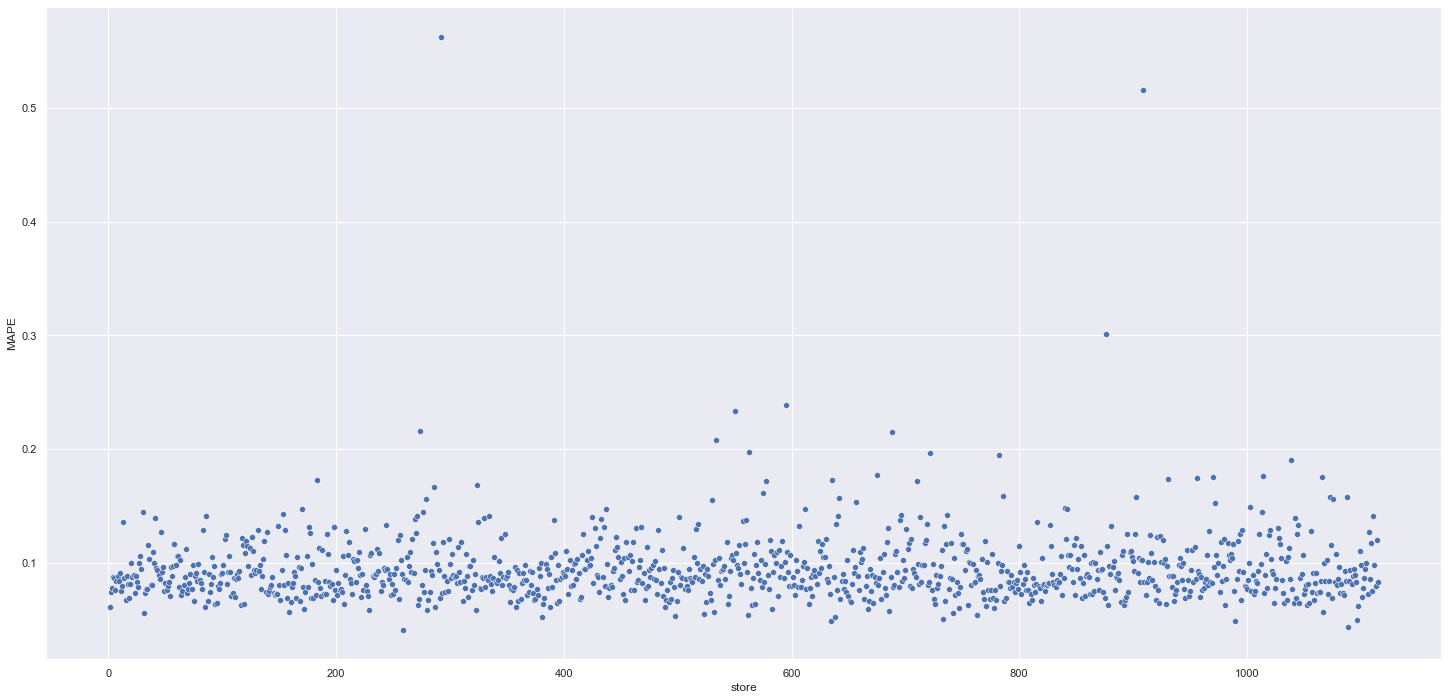

In [78]:
#sum of predctions
df91 = df9[['store','predctions']].groupby('store').sum().reset_index()

#MAE and MAPE
df9_aux1 = df9[['store','sales','predctions']].groupby('store').apply( lambda x : mean_absolute_error (x['sales'], x['predctions'])).reset_index().rename(columns = {0:'MAE'})
df9_aux2 = df9[['store','sales','predctions']].groupby('store').apply( lambda x : mean_absolute_percentage_error (x['sales'], x['predctions'])).reset_index().rename(columns = {0:'MAPE'})

#merge
df9_aux3 = pd.merge(df9_aux1,df9_aux2, how='inner', on = 'store')
df92 = pd.merge(df91, df9_aux3, how='inner', on = 'store')

#scenarios

df92['worst_scenario'] = df92['predctions'] - df92['MAE']
df92['best_scenario'] = df92['predctions'] + df92['MAE']

#order collumns
df92 = df92[['store', 'predctions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

sns.scatterplot( x = 'store', y = 'MAPE', data =df92);

## 9.1 TOTAL PERFORMANCE

In [79]:
df93 = df92[['predctions', 'worst_scenario', 'best_scenario']].apply(lambda x : np.sum(x), axis = 0).reset_index().rename(columns={'index':'scenarios',0:'values'})
df93['values'] = df93['values'].map( 'U$ {:.2f}'.format)
df93

,scenarios,values
0,predctions,U$ 283458976.00
1,worst_scenario,U$ 282733903.80
2,best_scenario,U$ 284184061.14


## 9.3 MACHINE LEARNING PERFORMANCE

In [85]:
df9['error'] = df9['sales'] - df9['predctions']
df9['error_rate'] = df9['predctions'] / df9['sales']

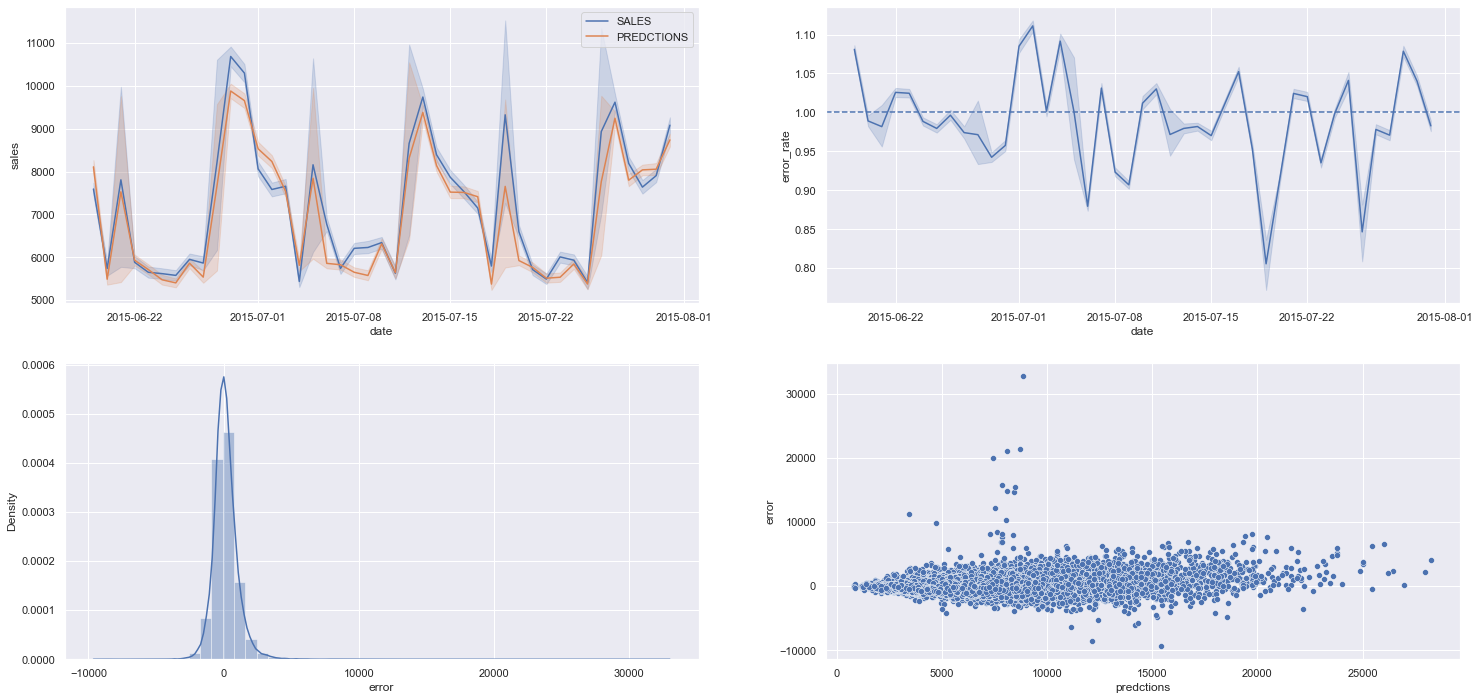

In [91]:
subplot(2,2,1)
sns.lineplot(x = 'date', y ='sales', data = df9, label= 'SALES')
sns.lineplot(x = 'date', y ='predctions', data = df9, label= 'PREDCTIONS')

subplot(2,2,2)
sns.lineplot( x= 'date', y='error_rate',data = df9)
plt.axhline(1, linestyle = '--')

subplot(2,2,3)
sns.distplot(df9['error'])

subplot(2,2,4)
sns.scatterplot(df9['predctions'], df9['error']);